In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt

In [2]:
class RBFNet():
    
    def __init__(self, nodes, sigma=1, eta=0.1):
        self.weights = None
        self.mu = None
        self.train_phi = None
        self.sigma = sigma
        self.nodes = nodes
        
    def even_rbf_center(self):
        mu_list = []
        for i in range(self.nodes):
            mu_list.append((i+0.5)*2*np.pi/(self.nodes))
        mu_list = np.reshape(np.array(mu_list), (len(mu_list),1))
        return mu_list
        
    def RBF(self, x, mu, sigma):
        return np.exp(-(np.power((x-mu),2))/(2*sigma**2))
    
    def calculate_phi(self, X):
        N = len(X)
        phi = np.zeros((N,self.nodes))
        for i in range(N):
            for j in range(self.nodes):
                phi[i,j] = self.RBF(X[i], self.mu[j], self.sigma)
        return phi
    
    def fit(self, X, y):      
        self.mu = self.even_rbf_center()
        self.train_phi = self.calculate_phi(X)
        phi_transpose = np.transpose(self.train_phi)
        self.weights = np.linalg.inv(np.dot(phi_transpose,self.train_phi)).dot(phi_transpose).dot(y)
       # print(self.weights.shape)
    
    def predict(self, X):
        phi = self.calculate_phi(X)
        return phi.dot(self.weights)

In [3]:
class RBFNet_delta():
    
    def __init__(self, nodes, sigma=1, eta=0.1, epochs=100):

        self.mu = None
        self.sigma = sigma
        self.nodes = nodes
        self.eta = eta
        self.epochs = epochs
        self.weights = None
       
        
    def even_rbf_center(self):
        mu_list = []
        for i in range(self.nodes):
            mu_list.append((i+0.5)*2*np.pi/(self.nodes))
        mu_list = np.reshape(np.array(mu_list), (len(mu_list),1))
        return mu_list
        
    def RBF(self, x, mu, sigma):
        return np.exp(-(np.linalg.norm(x-mu))/(2*sigma**2))
    
    def rbf(self, x, c, s):
        return np.exp(-1 / (2 * s**2) * (x-c)**2)
    
    def calculate_phi(self, X):
        N = len(X)
        phi = np.zeros((N,self.nodes))
        for i in range(N):
            for j in range(self.nodes):
                phi[i,j] = self.RBF(X[i], self.mu[j], self.sigma)
        return phi
    
    def fit(self, X, y):  
        
        np.random.seed(100)
        
        N = X.shape[0]
        permute = list(range(N))
        np.random.shuffle(permute)
        X = X[permute]
        y = y[permute]
        
        self.mu = self.even_rbf_center()
        #self.mu = np.random.normal(0, 2*math.pi, self.nodes)
        #print(self.mu)
        phi = self.calculate_phi(X)
        phi_train = np.concatenate((phi, np.ones((phi.shape[0], 1))), axis=1)
        #print(phi_train.shape)
        self.weights = np.random.randn(phi_train.shape[1],1)
        W = self.weights
        mse = []
        
        for i in range(self.epochs):
            for ind, value in enumerate(phi_train):
                value = np.reshape(value,(1, len(value)))
                #print(value)
                error = y[ind] - np.dot(value,W) 
                #print("error shape:" , error.shape)
                correction = self.eta*error*(value.T)     
                #print("cortection:",correction.shape)
                W [0: -1] += correction[0: -1]
                W [-1][0] +=  self.eta * error
        
            pred = phi_train.dot(self.weights)
            mse.append(np.mean(np.abs(pred-y)))   
        #print(self.weights)
        self.weights = W
        return mse

    def predict(self, X):
        phi = self.calculate_phi(X)
        phi_test = np.concatenate((phi, np.ones((phi.shape[0], 1))), axis=1)
        pred = phi_test.dot(self.weights) 
        return pred
    '''
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
           # print(a.shape, self.w.shape, self.b.shape)
            F = a.T.dot(self.w) + self.b
           # print('F',F.shape)
            y_pred.append(F)
        y_pred = np.reshape(y_pred,(X.shape[0],))
       # print(np.array(y_pred))
        return np.array(y_pred)
    '''    

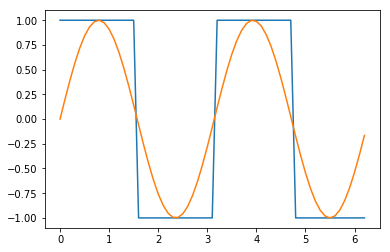

In [4]:
stepSize = 0.1
interval = [0, 2*math.pi]
trainStart = 0
testStart = 0.05

trainX = np.arange(interval[0]+trainStart, interval[1], stepSize)
testX = np.arange(interval[0]+testStart, interval[1], stepSize)

noise = np.random.normal(0, 0.1, len(trainX))
trainX_n = trainX + noise
testX_n = testX + noise

#sin(x)
trainSinY = np.sin(2*trainX) 
testSinY = np.sin(2*testX) 

#square(2x)
trainSqY = np.ones(len(trainSinY))
testSqY = np.ones(len(testSinY))
trainSqY[np.where(trainSinY>=0)] = 1
trainSqY[np.where(trainSinY < 0)]= -1

testSqY[np.where(testSinY>=0)] = 1
testSqY[np.where(testSinY < 0)]= -1

plt.plot(trainX, trainSqY)
plt.plot(trainX, trainSinY)



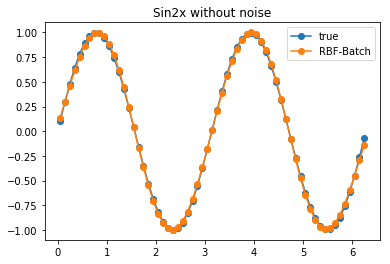

In [5]:
rbf = RBFNet(9,1)

rbf.fit(trainX, trainSinY)
y_pred = rbf.predict(testX)

plt.plot(testX, testSinY, '-o', label='true')
plt.plot(testX, y_pred, '-o', label='RBF-Batch')
plt.title('Sin2x without noise')
plt.legend()

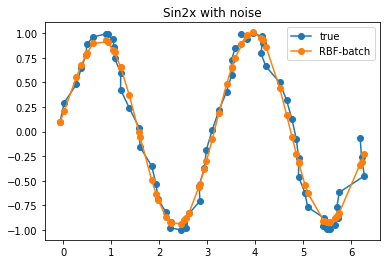

In [6]:
rbf = RBFNet(9,1)

rbf.fit(trainX_n, trainSinY)
y_pred = rbf.predict(testX_n)

plt.plot(testX_n, testSinY, '-o', label='true')
plt.plot(testX_n, y_pred, '-o', label='RBF-batch')
plt.title('Sin2x with noise')
plt.legend()

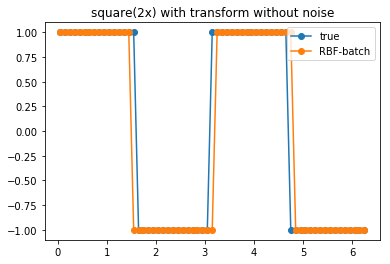

In [19]:
rbf = RBFNet(15,1)

rbf.fit(trainX, trainSqY)
y_pred = rbf.predict(testX)
y_pred_sq = [1 if i >= 0 else -1 for i in  y_pred]
plt.plot(testX, testSqY, '-o', label='true')
plt.plot(testX, y_pred_sq, '-o', label='RBF-batch')
plt.title('square(2x) with transform without noise')
plt.legend()

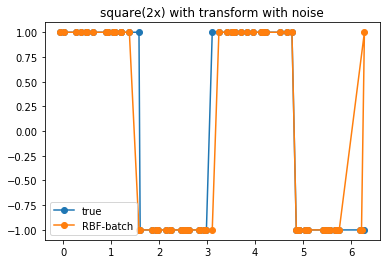

In [20]:
rbf = RBFNet(15,1)

rbf.fit(trainX_n, trainSqY)
y_pred = rbf.predict(testX_n)
y_pred_sq = [1 if i >= 0 else -1 for i in  y_pred]
plt.plot(testX_n, testSqY, '-o', label='true')
plt.plot(testX_n, y_pred_sq, '-o', label='RBF-batch')
plt.title('square(2x) with transform with noise')
plt.legend()

Text(0.5, 1.0, 'learning for RBF-delta, nodes=20 eta=0.2')

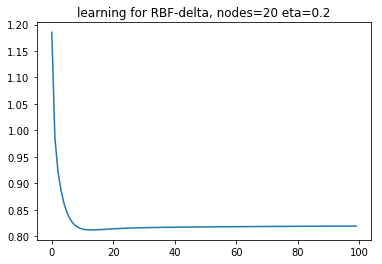

In [207]:
rbf_d = RBFNet_delta(20,1,0.2,100)
mse = rbf_d.fit(trainX, trainSinY)
plt.plot(mse)
plt.title('learning for RBF-delta, nodes=20 eta=0.2' )



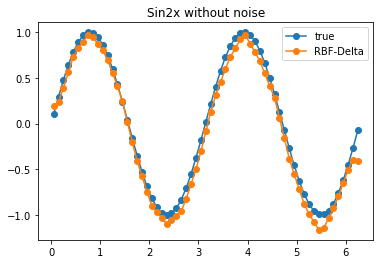

In [208]:
y_pred = rbf_d.predict(testX)
plt.plot(testX, testSinY, '-o', label='true')
plt.plot(testX, y_pred, '-o', label='RBF-Delta')
plt.title('Sin2x without noise')
plt.legend()

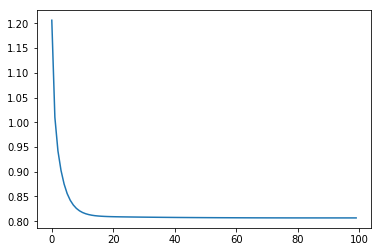

In [209]:
rbf_d = RBFNet_delta(20,1,0.2)

mse = rbf_d.fit(trainX_n, trainSinY)

plt.plot(mse)

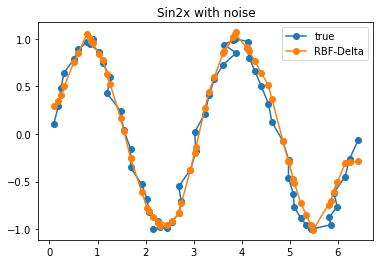

In [210]:
y_pred = rbf_d.predict(testX_n)

plt.plot(testX_n, testSinY, '-o', label='true')
plt.plot(testX_n, y_pred, '-o', label='RBF-Delta')
plt.title('Sin2x with noise')
plt.legend()

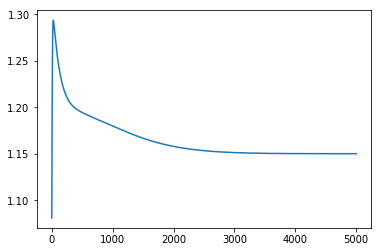

In [165]:
rbf_d = RBFNet_delta(20,1,0.2,5000)

mse = rbf_d.fit(trainX_n, trainSqY)

plt.plot(mse)



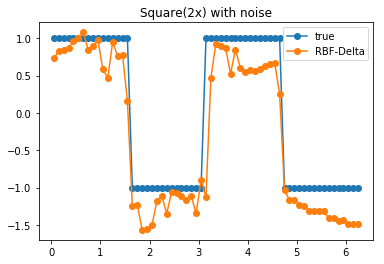

In [166]:
y_pred = rbf_d.predict(testX_n)

plt.plot(testX, testSqY, '-o', label='true')
plt.plot(testX, y_pred, '-o', label='RBF-Delta')
plt.title('Square(2x) with noise')
plt.legend()

In [ ]:
y_pred = rbf_d.predict(testX_n)

plt.plot(testX_n, testSqY, '-o', label='true')
plt.plot(testX_n, y_pred, '-o', label='RBF-Delta')
plt.title('Square(2x) with noise')
plt.legend()

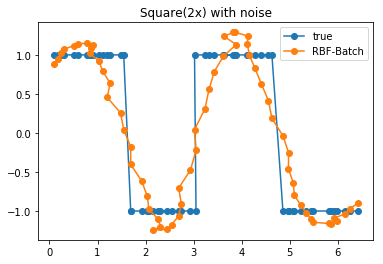

In [152]:
rbf = RBFNet(6,1)

rbf.fit(trainX_n, trainSqY)
y_pred = rbf.predict(testX)

plt.plot(testX_n, testSqY, '-o', label='true')
plt.plot(testX_n, y_pred, '-o', label='RBF-Batch')
plt.title('Square(2x) with noise')
plt.legend()

In [177]:
err = np.zeros([4, 62])
sigma = [0.5, 0.8, 1, 2]
for k in range(len(sigma)):
    for i in range(0,62):
        rbf = RBFNet(i+1,sigma[k])
        rbf.fit(trainX, trainSinY)
        y_pred_sin = rbf.predict(testX)
        sin_error = np.mean(np.abs(testSinY-y_pred_sin))
        err[k][i] = sin_error


Text(0.5, 1.0, 'Errors with nodes number without noise')

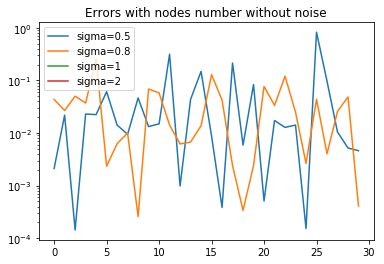

In [49]:
for i in range(4):
    plt.plot(range(0,30),err[i][:30])
    plt.yscale( 'log')
plt.legend(['sigma=0.5','sigma=0.8','sigma=1','sigma=2'])
plt.title('Errors with nodes number without noise')

In [180]:
err = np.zeros([4, 62])
sigma = [0.5, 0.8, 1, 2]
for k in range(len(sigma)):
    for i in range(0,62):
        rbf = RBFNet(i+1,sigma[k])
        rbf.fit(trainX_n, trainSinY)
        y_pred_sin = rbf.predict(testX_n)
        sin_error = np.mean(np.abs(testSinY-y_pred_sin))
        err[k][i] = sin_error
        


Text(0.5, 1.0, 'Errors with nodes number with noise')

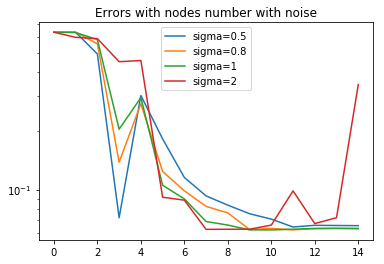

In [181]:
for i in range(4):
    plt.plot(range(0,15),err[i][:15])
plt.yscale( 'log')
plt.legend(['sigma=0.5','sigma=0.8','sigma=1','sigma=2'])
plt.title('Errors with nodes number with noise')

In [211]:

err = np.zeros([4, 62])
sigma = [0.5, 0.8, 1, 2]
for k in range(len(sigma)):
    for i in range(0,62):
        rbf_d= RBFNet_delta(i+1,sigma[k],0.1)
        rbf_d.fit(trainX, trainSinY)
        y_pred_sin = rbf_d.predict(testX)
        sin_error = np.mean(np.abs(testSinY-y_pred_sin))
        err[k][i] = sin_error

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in add
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in add


Text(0.5, 1.0, 'Delta rule RBF with sin(2x) without noise')

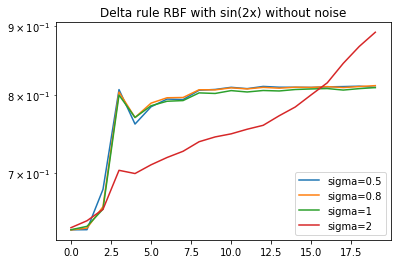

In [212]:
for i in range(4):
    plt.plot(range(0,20),err[i][:20])
    plt.yscale('log')
    plt.legend(['sigma=0.5','sigma=0.8','sigma=1','sigma=2'])
    plt.title('Delta rule RBF with sin(2x) without noise')

In [213]:

err = np.zeros([4, 62], dtype= np.float64)
sigma = [0.5, 0.8, 1, 2]
for k in range(len(sigma)):
    for i in range(0,62):
        rbf_d= RBFNet_delta(i+1,sigma[k],0.2)
        rbf_d.fit(trainX_n, trainSinY)
        y_pred_sin = rbf_d.predict(testX_n)
        sin_error = np.mean(np.abs(testSinY-y_pred_sin))
        err[k][i] = sin_error


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in add
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in add


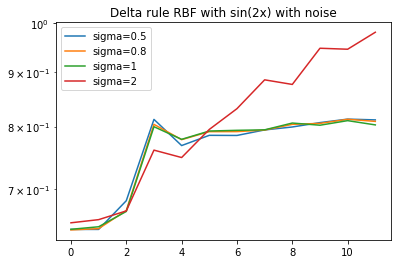

In [215]:
for i in range(4):
    plt.plot(range(0,12),err[i][:12])
    plt.yscale('log')
    plt.legend(['sigma=0.5','sigma=0.8','sigma=1','sigma=2'])
    plt.title('Delta rule RBF with sin(2x) with noise')

In [ ]:
err = []
for i in range(1,63):
    rbf = RBFNet(i,1)
    rbf.fit(trainX, trainSqY)
    y_pred_sq = rbf.predict(testX)
    # transform
    y_pred_sq = [1 if i >= 0 else -1 for i in  y_pred_sq]
    sq_error = np.mean(np.abs(testSqY - y_pred_sq))
    
    err.append(sq_error)


In [15]:
err = np.zeros([4, 62])
sigma = [0.5, 0.8, 1, 2]
for k in range(len(sigma)):
    for i in range(0,62):
        rbf = RBFNet(i+1,sigma[k])
        rbf.fit(trainX, trainSqY)
        y_pred_sq = rbf.predict(testX)
        # transform
        y_pred_sq = [1 if i >= 0 else -1 for i in  y_pred_sq]
        sq_error = np.mean(np.abs(testSqY - y_pred_sq))
        err[k][i] = sq_error
        


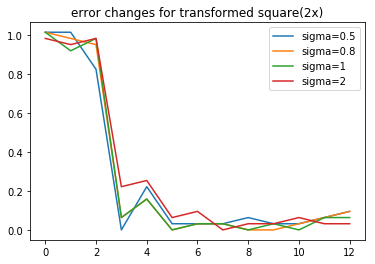

In [16]:
for i in range(4):
    plt.plot(range(0,13),err[i][:13])
    #plt.yscale( 'log')
    plt.legend(['sigma=0.5','sigma=0.8','sigma=1','sigma=2'])
    plt.title('error changes for transformed square(2x)')

In [ ]:
err = []
for i in range(1,63):
    rbf = RBFNet(i,2)
    rbf.fit(trainX, trainSinY)
    y_pred_sin = rbf.predict(testX)
    sin_error = np.mean(np.abs(testSinY - y_pred_sin))
    
    err.append(sin_error)
    print("RE",sin_error)
    if sin_error < 10e-15 :
        print("Zero error", i)
        print("RE", sin_error)
    elif sin_error<0.1:
        print("Less than 0.1", i)
        print("RE", sin_error)
    elif sin_error<0.01:
        print("Less than 0.01",i)
        print("RE", sin_error)
    elif sin_error<0.1:
        print("Less than 0.1",i)
        print("RE", sin_error)

In [64]:
class RBF_CL():
    
    def __init__(self, nodes, sigma=0.5, eta=0.1):
        self.weights = None
        self.mu = None
        self.train_phi = None
        self.sigma = sigma
        self.nodes = nodes
        self.eta = eta
        
    def even_rbf_center(self):
        mu_list = []
        for i in range(self.nodes):
            mu_list.append((i+0.5)*2*np.pi/(self.nodes))
        mu_list = np.reshape(np.array(mu_list), (len(mu_list),1))
        return mu_list
    
    def competetive_RBF_centers(self,data1, nodecount, eta, iterations):
        data = data1.copy()
        np.random.shuffle(data)
        RBF = data[0:nodecount].copy()
        #print(RBF.T)
        for j in range(iterations):
            randvec = data[np.random.randint(0,len(data))] #Breaks down in multidimensional case
            distances = np.empty((0,0))
            for center in RBF:
                distances = np.append(distances,(np.linalg.norm(center-randvec)))

            #RBF[distances.argmin()] += eta * (randvec-RBF[distances.argmin()]) #一次更新distance最小的一个
            
            RBF = RBF[np.argsort(distances)] #将元素从小到大排列，提取元素的原序号输出 (一次更新多点？)
            for i in range(len(RBF)): #一次更新多个
                RBF[i] += (eta * (randvec - RBF[i]))/(np.square(i+1)) #eta/(np.square(i+1))距离越远更新的eta变小
            
        #print (RBF.T)
        return RBF
    
    def RBF(self, x, mu, sigma):
        return np.exp(-(np.power((x-mu),2))/(2*sigma**2))
    
    def calculate_phi(self, X):
        N = len(X)
        phi = np.zeros((N,self.nodes))
        for i in range(N):
            for j in range(self.nodes):
                phi[i,j] = self.RBF(X[i], self.mu[j], self.sigma)
        return phi
    
    def fit(self, X, y): 
        iterations = 1000
        self.mu = self.competetive_RBF_centers(X, self.nodes, self.eta, iterations)
        self.train_phi = self.calculate_phi(X)
        phi_transpose = np.transpose(self.train_phi)
        self.weights = np.linalg.inv(np.dot(phi_transpose,self.train_phi)).dot(phi_transpose).dot(y)
       # print(self.weights.shape)
    
    def predict(self, X):
        phi = self.calculate_phi(X)
        return phi.dot(self.weights)

In [42]:
cl = RBF_CL(15,1)
cl.fit(trainX, trainSinY)
y_pred = cl.predict(testX)

[0.4 2.  2.5 0.9 1.4 4.3 3.2 1.3 4.9 2.8 4.  0.2 6.  1.5 6.1]
[0.44771252 2.05034503 2.42088806 0.75705894 1.37342734 4.50380479
 3.35651535 1.09777897 4.99253658 2.92967014 3.91250943 0.10717591
 5.5422269  1.68724613 5.99826571]


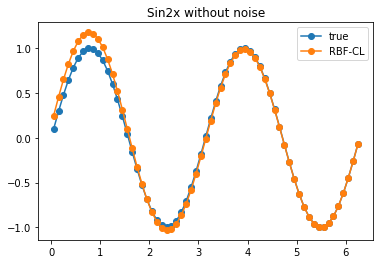

In [43]:
plt.plot(testX, testSinY, '-o', label='true')
plt.plot(testX, y_pred, '-o', label='RBF-CL')
plt.title('Sin2x without noise')
plt.legend()

[4.85306933 0.44550608 4.85540966 5.66657028 1.00912626 1.1509331
 5.38592473 1.93368018 1.02351063 3.65474438 4.60491766 2.93526508
 3.531577   4.06659595 1.79616187]
[4.80507031 0.14643644 5.00539227 6.17324369 0.56518204 1.2002081
 5.55894084 2.0781944  0.97211732 3.65268397 4.51948078 2.66128783
 3.31762021 4.03261021 1.64523381]


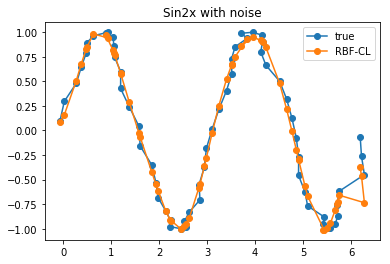

In [44]:
cl = RBF_CL(15,1)
cl.fit(trainX_n, trainSinY)
y_pred = cl.predict(testX_n)
plt.plot(testX_n, testSinY, '-o', label='true')
plt.plot(testX_n, y_pred, '-o', label='RBF-CL')
plt.title('Sin2x with noise')
plt.legend()

In [67]:
err = np.zeros([4, 62])
sigma = [0.2, 0.5,0.8]
for k in range(len(sigma)):
    for i in range(0,62):
        cl = RBF_CL(i+1,sigma[k])
        cl.fit(trainX, trainSinY)
        y_pred = cl.predict(testX)
        sin_error = np.mean(np.abs(testSinY-y_pred))
        err[k][i] = sin_error
        

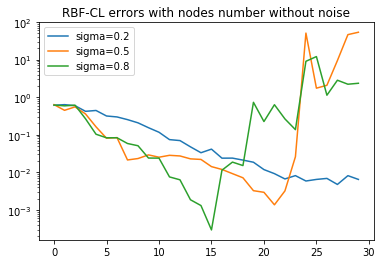

In [68]:
for i in range(3):
    plt.plot(range(0,30),err[i][:30])
    plt.yscale( 'log')
    plt.legend(['sigma=0.2','sigma=0.5','sigma=0.8'])
    plt.title('RBF-CL errors with nodes number without noise')

In [71]:
class RBF_delta_CL():
    
    def __init__(self, nodes, sigma=1, eta=0.1, epochs=100):

        self.mu = None
        self.sigma = sigma
        self.nodes = nodes
        self.eta = eta
        self.epochs = epochs
        self.weights = None
       
        
    def even_rbf_center(self):
        mu_list = []
        for i in range(self.nodes):
            mu_list.append((i+0.5)*2*np.pi/(self.nodes))
        mu_list = np.reshape(np.array(mu_list), (len(mu_list),1))
        return mu_list
    
    def competetive_RBF_centers(self,data1, nodecount, eta, iterations):
        data = data1.copy()
        np.random.shuffle(data)
        RBF = data[0:nodecount].copy()
        #print(RBF.T)
        for j in range(iterations):
            randvec = data[np.random.randint(0,len(data))] #Breaks down in multidimensional case
            distances = np.empty((0,0))
            for center in RBF:
                distances = np.append(distances,(np.linalg.norm(center-randvec)))

            RBF[distances.argmin()] += eta * (randvec-RBF[distances.argmin()]) #一次更新distance最小的一个
            
           # RBF = RBF[np.argsort(distances)] #将元素从小到大排列，提取元素的原序号输出 (一次更新多点？)
           # for i in range(len(RBF)): #一次更新多个
           #     RBF[i] += (eta * (randvec - RBF[i]))/(np.square(i+1)) #eta/(np.square(i+1))距离越远更新的eta变小
            
        #print (RBF.T)
        return RBF
        
    def RBF(self, x, mu, sigma):
        return np.exp(-(np.linalg.norm(x-mu))/(2*sigma**2))
    
    def rbf(self, x, c, s):
        return np.exp(-1 / (2 * s**2) * (x-c)**2)
    
    def calculate_phi(self, X):
        N = len(X)
        phi = np.zeros((N,self.nodes))
        for i in range(N):
            for j in range(self.nodes):
                phi[i,j] = self.RBF(X[i], self.mu[j], self.sigma)
        return phi
    
    def fit(self, X, y):  
        
        np.random.seed(100)
        
        N = X.shape[0]
        permute = list(range(N))
        np.random.shuffle(permute)
        X = X[permute]
        y = y[permute]
        
        iterations = 1000
        self.mu = self.competetive_RBF_centers(X, self.nodes, self.eta, iterations)
        #self.mu = np.random.normal(0, 2*math.pi, self.nodes)
        #print(self.mu)
        phi = self.calculate_phi(X)
        phi_train = np.concatenate((phi, np.ones((phi.shape[0], 1))), axis=1)
        #print(phi_train.shape)
        self.weights = np.random.randn(phi_train.shape[1],1)
        W = self.weights
        mse = []
        
        for i in range(self.epochs):
            for ind, value in enumerate(phi_train):
                value = np.reshape(value,(1, len(value)))
                #print(value)
                error = y[ind] - np.dot(value,W) 
                #print("error shape:" , error.shape)
                correction = self.eta*error*(value.T)     
                #print("cortection:",correction.shape)
                W [0: -1] += correction[0: -1]
                W [-1][0] +=  self.eta * error
        
            pred = phi_train.dot(self.weights)
            mse.append(np.mean(np.abs(pred-y)))   
        #print(self.weights)
        self.weights = W
        return mse

    def predict(self, X):
        phi = self.calculate_phi(X)
        phi_test = np.concatenate((phi, np.ones((phi.shape[0], 1))), axis=1)
        pred = phi_test.dot(self.weights) 
        return pred

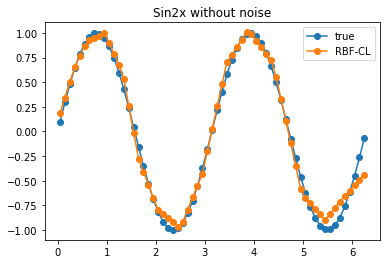

In [73]:
cl = RBF_delta_CL(15,1)
cl.fit(trainX, trainSinY)
y_pred = cl.predict(testX)
plt.plot(testX, testSinY, '-o', label='true')
plt.plot(testX, y_pred, '-o', label='RBF-CL')
plt.title('Sin2x without noise')
plt.legend()

In [81]:
err = np.zeros([4, 62])
sigma = [0.2, 0.5,0.8]
for k in range(len(sigma)):
    for i in range(0,62):
        cl = RBF_delta_CL(i+1,sigma[k])
        cl.fit(trainX, trainSinY)
        y_pred = cl.predict(testX)
        sin_error = np.mean(np.abs(testSinY-y_pred))
        err[k][i] = sin_error

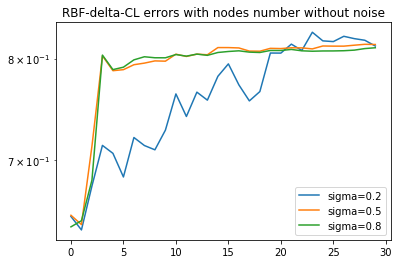

In [82]:
for i in range(3):
    plt.plot(range(0,30),err[i][:30])
    plt.yscale( 'log')
    plt.legend(['sigma=0.2','sigma=0.5','sigma=0.8'])
    plt.title('RBF-delta-CL errors with nodes number without noise')